In [14]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from safetensors import safe_open 
from scipy import stats

In [15]:
import matplotlib
import pandas as pd
matplotlib.__version__
np.__version__
pd.__version__

'2.0.3'

In [16]:
dataset_name = "imagenette2" #"imagenet"
model_name = "resnet34_timm" # "resnet101_timm"
SPLIT = "test"
layer_name = "block_3" # you investigate mixed-selectivity of neurons in this layer.  

tensors = {}
path = f"../../../results/global_features/{dataset_name}/{model_name}"
with safe_open(f"{path}/latent_embeddings_{layer_name}_{SPLIT}.safetensors", framework="pt", device="cpu") as f:
   for key in f.keys():
       tensors[key] = f.get_tensor(key)

M = 50    # number of reference samples
CLIP_embeddings = tensors["CLIP"][:, :M]
DINO_embeddings = tensors["DINO"][:, :M]

tensors = {}
path = f"../../../results/global_features/{dataset_name}/{model_name}"
with safe_open(f"{path}/latent_features_{layer_name}_{SPLIT}.safetensors", framework="pt", device="cpu") as f:
    for key in f.keys():
        tensors[key] = f.get_tensor(key)

PURE_embeddings = tensors["cond_rel"][:, :M]
ACT_embeddings = tensors["mean_act"][:, :M]

In [17]:
label = ["DINOv2", "PURE", "activations"]
X = [DINO_embeddings, PURE_embeddings, ACT_embeddings]
X_0 = CLIP_embeddings

n_subsets = 30
len_subset = X_0.shape[0] // n_subsets
random_indices = np.random.choice(X_0.shape[0], X_0.shape[0], replace=False)
subsets = [random_indices[(i)*len_subset:(i+1)*len_subset] for i in range(n_subsets)]

Y = [[] for x in X]

for k, subset in enumerate(subsets):
    x_0 = torch.norm(X_0[subset][:, None] - X_0[subset][:, :, None], dim=3).flatten()
    x_ = [
        torch.norm(x[subset][:, None] - x[subset][:, :, None], dim=3).flatten()
        for x in X
    ]
    
    for i, x in enumerate(x_):
        zeros = (x_0 * x) == 0
        dist_x = x[zeros == False]
        dist_x_0 = x_0[zeros == False]
        Y[i].append(np.corrcoef(dist_x_0, dist_x)[0, 1])
        

findfont: Generic family 'sans-serif' not found because none of the following families were found: Roboto
findfont: Generic family 'sans-serif' not found because none of the following families were found: Roboto
findfont: Generic family 'sans-serif' not found because none of the following families were found: Roboto
findfont: Generic family 'sans-serif' not found because none of the following families were found: Roboto
findfont: Generic family 'sans-serif' not found because none of the following families were found: Roboto
findfont: Generic family 'sans-serif' not found because none of the following families were found: Roboto
findfont: Generic family 'sans-serif' not found because none of the following families were found: Roboto


findfont: Generic family 'sans-serif' not found because none of the following families were found: Roboto
findfont: Generic family 'sans-serif' not found because none of the following families were found: Roboto
findfont: Generic family 'sans-serif' not found because none of the following families were found: Roboto
findfont: Generic family 'sans-serif' not found because none of the following families were found: Roboto
findfont: Generic family 'sans-serif' not found because none of the following families were found: Roboto
findfont: Generic family 'sans-serif' not found because none of the following families were found: Roboto
findfont: Generic family 'sans-serif' not found because none of the following families were found: Roboto
findfont: Generic family 'sans-serif' not found because none of the following families were found: Roboto
findfont: Generic family 'sans-serif' not found because none of the following families were found: Roboto
findfont: Generic family 'sans-serif' not foun

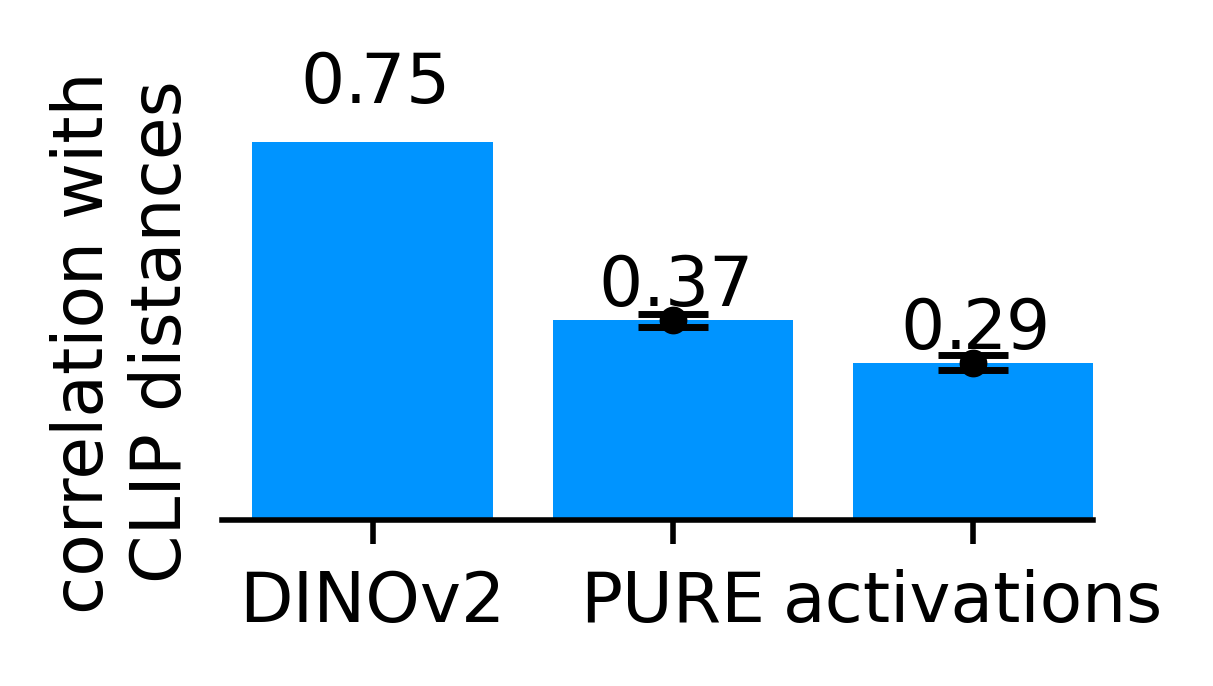

In [18]:
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'Roboto'
fig, ax = plt.subplots(1, 1, dpi=500, figsize=(2.5, 1.5)) 

correlations = [np.mean(y) for y in Y]
plt.bar(label, correlations, color="#0094FF")
plt.errorbar(np.arange(len(label)),
             [np.mean(y) for y in Y],
             yerr=[np.std(y)/np.sqrt(len(y)) for y in Y],
             color='k', fmt='.', elinewidth=0.1, capsize=5)
for i, m in enumerate(correlations):
    plt.text(i, m + 0.001, f"${m:.2f}$", ha="center", va="bottom")
plt.ylim(0, 0.7)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
# ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
plt.ylabel("correlation with \nCLIP distances")
plt.yticks([])
plt.xlim(-0.5, len(correlations)-0.6)
plt.tight_layout()

plt.savefig(f"correlation_CLIP_{model_name}.svg", dpi=300)
plt.show()

findfont: Generic family 'sans-serif' not found because none of the following families were found: Roboto
findfont: Generic family 'sans-serif' not found because none of the following families were found: Roboto
findfont: Generic family 'sans-serif' not found because none of the following families were found: Roboto
findfont: Generic family 'sans-serif' not found because none of the following families were found: Roboto
findfont: Generic family 'sans-serif' not found because none of the following families were found: Roboto
findfont: Generic family 'sans-serif' not found because none of the following families were found: Roboto
findfont: Generic family 'sans-serif' not found because none of the following families were found: Roboto
findfont: Generic family 'sans-serif' not found because none of the following families were found: Roboto
findfont: Generic family 'sans-serif' not found because none of the following families were found: Roboto
findfont: Generic family 'sans-serif' not foun

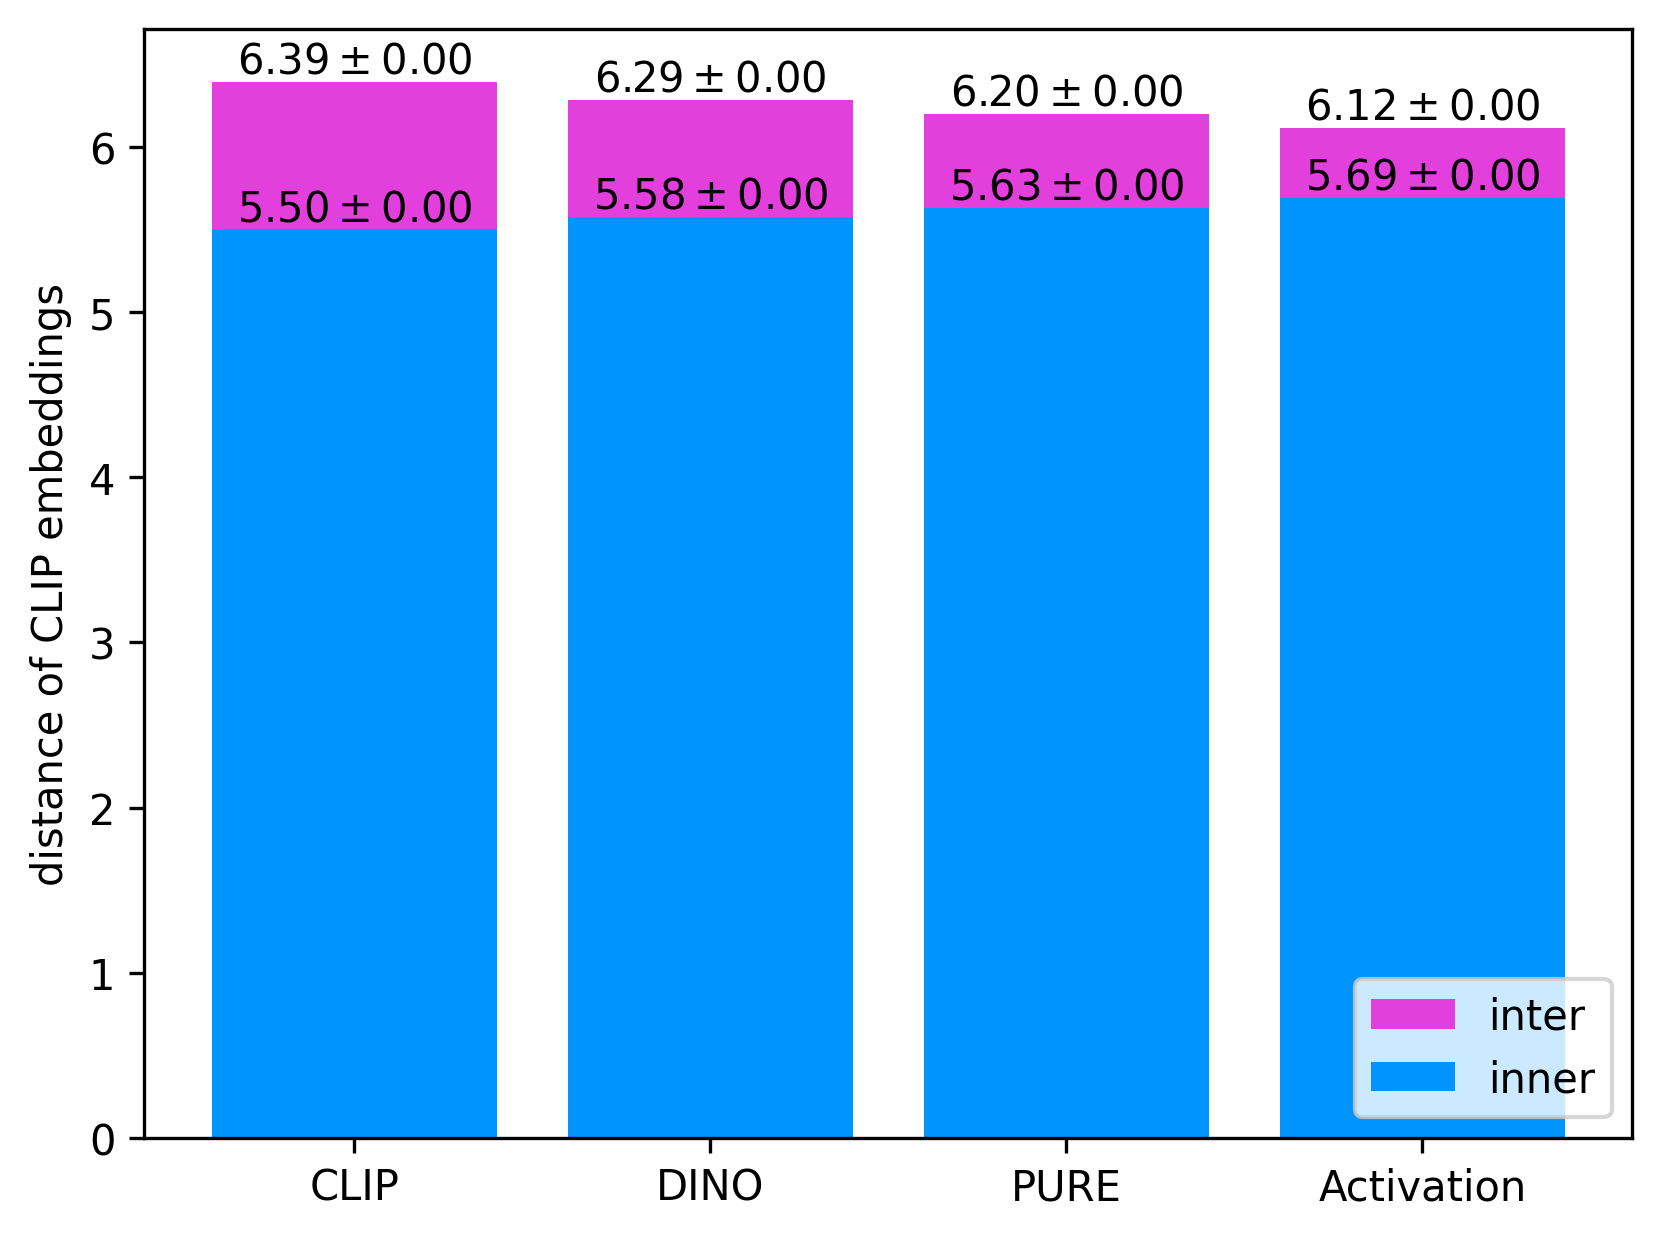

In [19]:
# Yota added this section: copied from eval_CLIP_alignment.py

n_clusters = 2

path = f"../../../results/interpretability/{dataset_name}/{model_name}"
vals_full = torch.load(f"{path}/interpretability_{n_clusters}clusters_{layer_name}_{SPLIT}.pt")

inner_CLIP = vals_full["CLIP"][0]
inter_CLIP = vals_full["CLIP"][1]
inner_rel = vals_full["PURE"][0]
inter_rel = vals_full["PURE"][1]
inner_act = vals_full["Activation"][0]
inter_act = vals_full["Activation"][1]
inner_dino = vals_full["DINO"][0]
inter_dino = vals_full["DINO"][1]
overall_ = vals_full["overall"]
neuron_indices = vals_full["neuron_indices"]

# vals_full = {
#     "CLIP": [inner_CLIP, inter_CLIP],
#     "PURE": [inner_rel, inter_rel],
#     "Activation": [inner_act, inter_act],
#     "DINO": [inner_dino, inter_dino],
#     "overall": overall_,
#     "neuron_indices": neuron_indices,
# }

vals = {
    "CLIP": [np.mean(inner_CLIP), np.mean(inter_CLIP), np.std(inner_CLIP) / len(inner_CLIP),
             np.std(inter_CLIP) / len(inter_CLIP)],
    "PURE": [np.mean(inner_rel), np.mean(inter_rel), np.std(inner_rel) / len(inner_rel),
             np.std(inter_rel) / len(inter_rel)],
    "Activation": [np.mean(inner_act), np.mean(inter_act), np.std(inner_act) / len(inner_act),
                   np.std(inter_act) / len(inter_act)],
    "DINO": [np.mean(inner_dino), np.mean(inter_dino), np.std(inner_dino) / len(inner_dino),
                   np.std(inter_dino) / len(inter_dino)],
}

plt.rcParams['text.usetex'] = False
plt.figure(dpi=300)

x = ["CLIP", "DINO", "PURE", "Activation"]

overall = np.mean(overall_)

plt.bar(x, height=[vals[m][1] for m in x], label="inter", color="#E33FDD")
plt.bar(x, height=[vals[m][0] for m in x], label="inner", color="#0094FF")
for i, m in enumerate(x):
    plt.text(i, vals[m][0], f"${vals[m][0]:.2f}\pm{vals[m][2]:.2f}$", ha="center", va="bottom")
    plt.text(i, vals[m][1], f"${vals[m][1]:.2f}\pm{vals[m][3]:.2f}$", ha="center", va="bottom")
    # plt.text(i, vals[m][0], f"{vals[m][0]:.2f}", ha="center", va="bottom")

plt.legend(loc="lower right")
plt.ylabel("distance of CLIP embeddings")
plt.show()

## the following part does not work (from the git repo)


In [12]:
bars[0].tolist()


NameError: name 'clip' is not defined

findfont: Generic family 'sans-serif' not found because none of the following families were found: Roboto
findfont: Generic family 'sans-serif' not found because none of the following families were found: Roboto
findfont: Generic family 'sans-serif' not found because none of the following families were found: Roboto
findfont: Generic family 'sans-serif' not found because none of the following families were found: Roboto
findfont: Generic family 'sans-serif' not found because none of the following families were found: Roboto
findfont: Generic family 'sans-serif' not found because none of the following families were found: Roboto
findfont: Generic family 'sans-serif' not found because none of the following families were found: Roboto
findfont: Generic family 'sans-serif' not found because none of the following families were found: Roboto
findfont: Generic family 'sans-serif' not found because none of the following families were found: Roboto
findfont: Generic family 'sans-serif' not foun

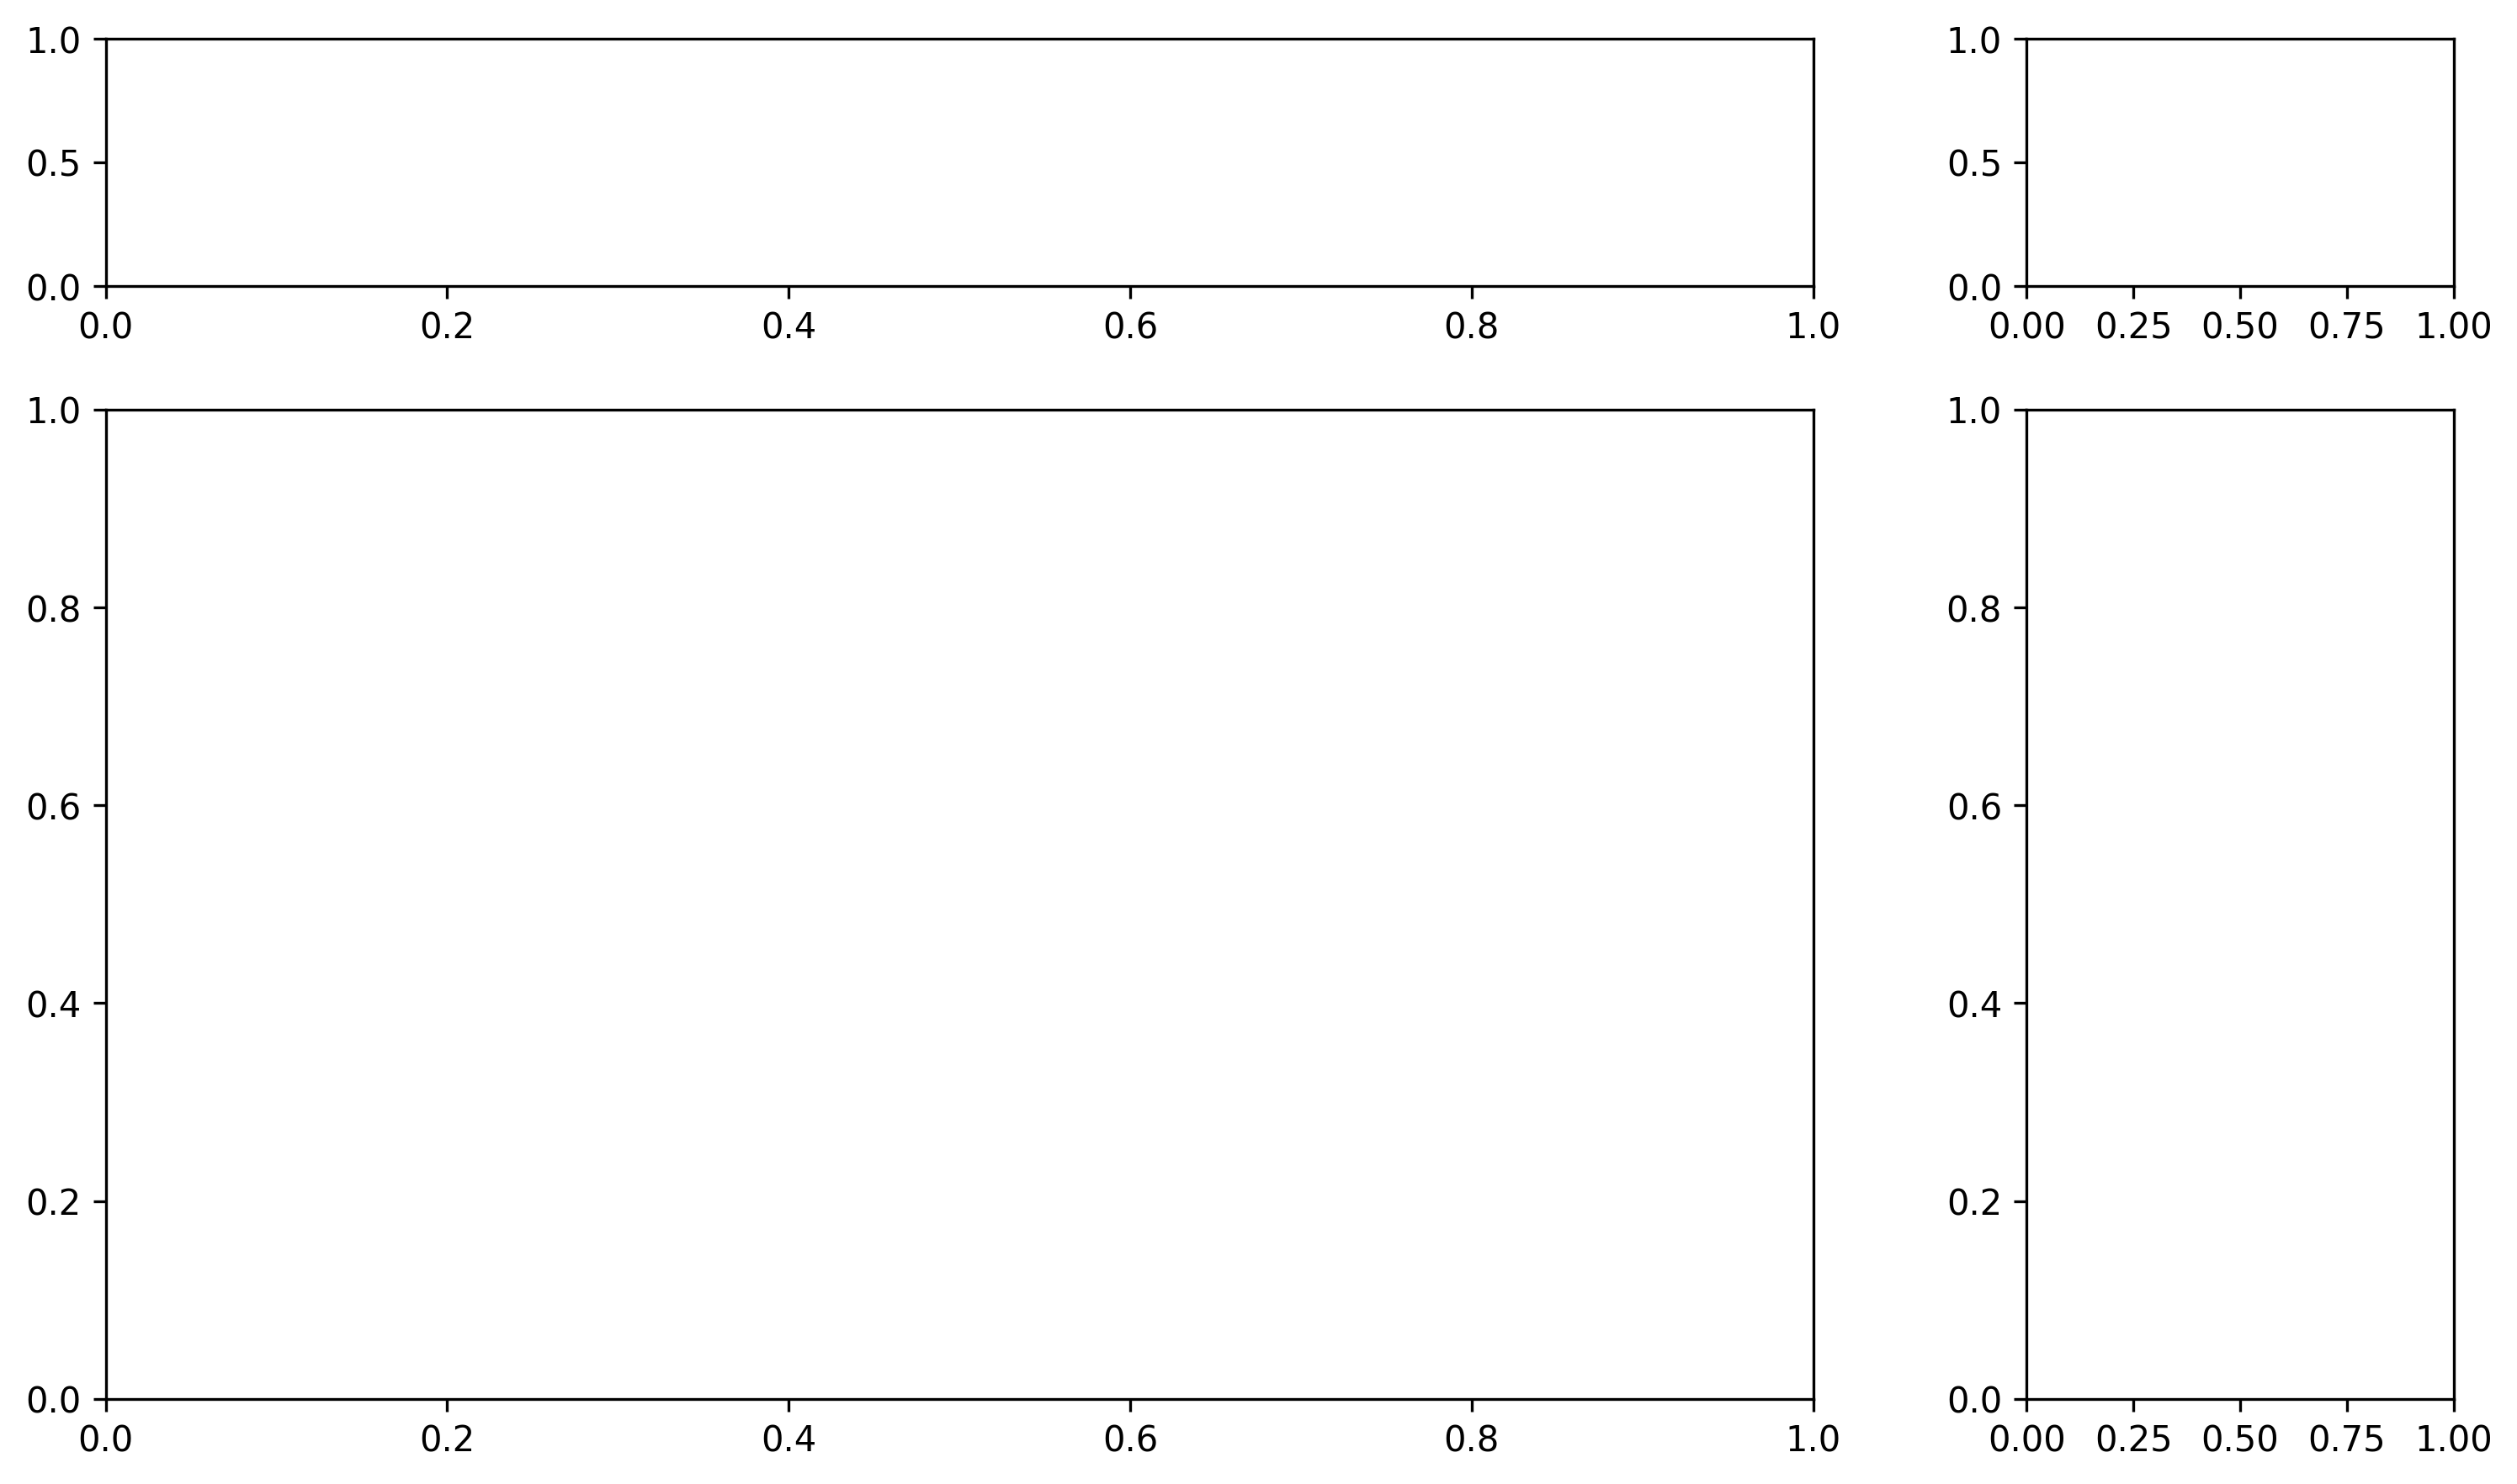

In [11]:
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'Roboto'
fig, axs = plt.subplots(2, 2, dpi=300, figsize=(12, 7),
                            gridspec_kw={'height_ratios': [1, 4], 'width_ratios': [4, 1]},)

x = overall
y = (clip[0] - overall) #/ overall

axs[1][0].scatter(x, y, alpha=0.8, color="#0094FF")
axs[1][0].set_xlabel("overall CLIP embedding distance")
axs[1][0].set_ylabel("$\\rho_{{inter}} - \\rho_{{intra}}$ / inter$-$intra-cluster distance of CLIP embedding ")

bars = axs[0][0].hist(x, bins=10, color="#0094FF")
delta_y = (bars[1][0] - bars[1][1]) / 2
for i, y_ in enumerate(zip(bars[0].tolist(), bars[1].tolist())):
    axs[0][0].text(y_[1] - delta_y, y_[0], int(y_[0]), ha="center", va="bottom")
axs[0][0].set_xlim(axs[1][0].get_xlim())
axs[0][0].set_ylim(axs[0][0].get_ylim()[0], axs[0][0].get_ylim()[1] + 40)
axs[0][0].set_xticks([])

bars = axs[1][1].hist(y, orientation="horizontal", bins=10, color="#0094FF")
delta_y = (bars[1][0] - bars[1][1]) / 2
for i, y_ in enumerate(zip(bars[0].tolist(), bars[1].tolist())):
    axs[1][1].text(y_[0], y_[1] - delta_y, int(y_[0]), ha="left", va="center")
axs[1][1].set_ylim(axs[1][0].get_ylim())
axs[1][1].set_yticks([])
axs[1][1].set_xlim(axs[1][1].get_xlim()[0], axs[1][1].get_xlim()[1] + 60)
axs[1][1].set_xlabel("number of neurons")

for t in np.argsort(y)[:10]:
    axs[1][0].text(x[t], y[t], indices[t].item())

for t in np.argsort(x)[:10:2]:
    axs[1][0].text(x[t], y[t], indices[t].item())

for t in np.argsort(-np.array(x))[:5]:
    axs[1][0].text(x[t], y[t], indices[t].item())

fig.delaxes(axs[0][1])
plt.tight_layout()
plt.savefig("CLIP_distribution.pdf", dpi=300)

In [ ]:
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'Roboto'

fig, ax = plt.subplots(1, 1, dpi=500, figsize=(3, 1.7)) 

x = ["DINO", "PURE", "Activation"]
labels = {
    "DINO": "DINOv2",
    "PURE": "PURE",
    "Activation": "activations",
    "random": "random"
}


overall = np.mean(data["overall"])

plt.bar(x, height=[np.mean(data[m][1]) - np.mean(data[m][0]) for m in x], bottom=[np.mean(data[m][0]) for m in x], alpha=1, color="#0094FF")
# plt.bar(x, height=[np.mean(data[m][0]) for m in x], color="white")

for i in range(len(x)):     
    plt.plot([x[i], x[i]], [np.mean(data[x[i]][0]), np.mean(data[x[i]][1])], 'k-')

plt.plot(x, [np.mean(data[m][1]) for m in x], 'ko', label="inter clusters")
plt.plot(x, [np.mean(data[m][0]) for m in x], 'ks', label="intra clusters")

for i, m in enumerate(x):
    plt.text(i, np.mean(data[m][0]) - 0.08, f"${np.mean(data[m][0]):.2f}$", ha="center", va="top")
    plt.text(i, np.mean(data[m][1]) + 0.06, f"${np.mean(data[m][1]):.2f}$", ha="center", va="bottom")
    # plt.text(i, vals[m][0], f"{vals[m][0]:.2f}", ha="center", va="bottom")

    
plt.plot(x + ["random"], [0 for m in x] + [overall], 'ks')
plt.text("random", overall - 0.08, f"${overall:.2f}$", ha="center", va="top")
# plt.text("random", overall + 0.06, f"${overall:.2f}$", ha="center", va="bottom")
# plt.errorbar(np.arange(len(x)),
#              [vals[m][0] for m in x],
#              yerr=[vals[m][2] for m in x],
#              color='k', fmt='.', elinewidth=1, capsize=5)
# plt.errorbar(np.arange(len(x)),
#              [vals[m][1] for m in x],
#              yerr=[vals[m][3] for m in x],
#              color='k', fmt='.', elinewidth=1, capsize=5)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
# ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

plt.legend(loc="upper right", fontsize="small")
plt.ylabel("distance of\nCLIP embeddings")
plt.ylim(5.5, plt.ylim()[1])
plt.yticks([5.5, 6, 6.5, 7])
plt.yticks([])
plt.xticks(np.arange(len(x) + 1), [labels[l] for l in x] + ["random"])
plt.xlim(-0.3, len(x) + 0.3)
plt.tight_layout()
plt.savefig("interpretability_CLIP.pdf", dpi=300)
plt.savefig("interpretability_CLIP.svg", dpi=300)
plt.show()

In [ ]:
np.where(data["PURE"][1] == "nan")

In [ ]:
indices = data["neuron_indices"]

In [ ]:
dc = np.array(data['CLIP'][1]) - np.array(data['CLIP'][0])
dr = np.array(data['PURE'][1]) - np.array(data['PURE'][0])
da = np.array(data['Activation'][1]) - np.array(data['Activation'][0])
dd = np.array(data['DINO'][1]) - np.array(data['DINO'][0])

In [ ]:
filt = dc > 1.5
da[filt][np.argsort(abs(dc[filt]))]

In [ ]:
indices[filt][np.argsort(-abs(dc[filt] - da[filt]) + abs(dc[filt] - dd[filt])) ]

In [ ]:
indices[filt][np.argsort(abs(dc[filt] - dd[filt])) ]

In [ ]:
dd[filt].mean()

In [ ]:
da[filt].mean()

In [ ]:
indices[filt][np.argsort((-dc[filt] - 1*dr[filt]))]

In [ ]:
len(indices)